In [2]:
import numpy as np
import matplotlib.pyplot as plt
import helpers.cusplot as cplt
import scipy.constants as c

## constants (SI)

In [15]:
## general
rho = 0.018 # spec. res. of Cu [Ohm*mm2/m]
A = 25 # Conductor c.s. [mm2]
cdens = 10 # max. current density [A/mm2] 

## kicker
brho = 0.98 
lgap = 0.09
hap = 0.1 # horizontal aperture (pole width)
kick_l = 0.5

N = 20


B_max = 0.064

B = B_max + 0.01 # puffer B-field 10 mT
NI = B/c.mu_0*lgap # for ferrite kicker

l_wind = 2*kick_l + 2*hap # len. of winding

## charge distribution
sigma = 0.015
delta_x_max = 0.01

## septum
w = 0.005 # 5 mm thickness for DC septum (CERN paper)
# assuming infinte extend in y (valid - 100 mm beam tube > 6 sigma)

In [4]:
# conv. turns to current (display if j > 10 A/mm2)
def N_to_I(N):
    if N != 0:
        I = NI/N
    else:
        I = NI
    return round(I,2)

### inductance (N turns) / Time constant (Ferrite kicker)

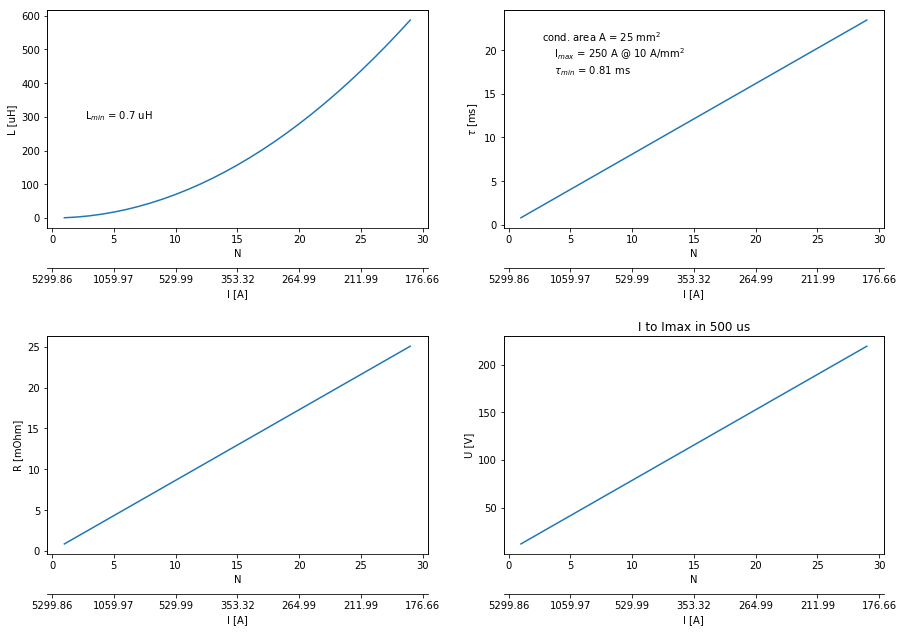

In [32]:
# induct. vs. turns vs. current

# turns
N_arr = np.arange(1,30)
I_arr = NI/N_arr

# inductance in uH
L_arr = c.mu_0*N_arr**2*hap/lgap*kick_l
# time constant in s
# resistance in copper
R_arr = rho/A*l_wind*N_arr


tau = L_arr/R_arr

fig, axes = plt.subplots(2,2, figsize = (15,10))
plt.subplots_adjust(hspace = 0.5)

axes[0,0].plot(N_arr,L_arr*1e6)
axes[0,0].set_ylabel('L [uH]')
axes[0,0].set_xlabel('N')
axes[0,0].text(0.1,0.5, r'L$_{{min}}$ = {} uH'.format(round(L_arr[0]*1e6,2)),transform=axes[0,0].transAxes)

cplt.add_axis(axes[0,0], 'x', N_to_I, 'I [A]')

axes[0,1].plot(N_arr,tau*1e3)
axes[0,1].set_ylabel(r'$\tau$ [ms]')
axes[0,1].set_xlabel('N')
axes[0,1].text(
    0.1,0.7,
    r'''cond. area A = {} mm$^2$
    I$_{{max}}$ = {} A @ 10 A/mm$^2$
    $\tau_{{min}}$ = {} ms'''.format(A,round(cdens*A,2),round(tau[0]*1e3,2)),
    transform=axes[0,1].transAxes)


       
       
cplt.add_axis(axes[0,1], 'x', N_to_I, 'I [A]')

axes[1,0].plot(N_arr, R_arr*1e3)
axes[1,0].set_ylabel('R [mOhm]')
axes[1,0].set_xlabel('N')

cplt.add_axis(axes[1,0], 'x', N_to_I, 'I [A]')

# TODO: correct for U_total = LI' + RI
axes[1,1].plot(N_arr,L_arr*I_arr/(500*1e-6)+R_arr*I_arr)
axes[1,1].set_ylabel('U [V]')
axes[1,1].set_xlabel('N')

axes[1,1].set_title('I to Imax in 500 us')

cplt.add_axis(axes[1,1], 'x', N_to_I, 'I [A]')


plt.savefig('/home/marius/Jülich/Multiplexer/Plots/kickseptum_study', format = 'png', dpi=900)
plt.show()

### septum irradiation / gfr

In [98]:
# numeric integration of current fraction 
def num_gauss_int(a,b,dx_max,seq_dx,seq_int,sigma):
    d = {}

    for delta_x in np.linspace(0,dx_max,seq_dx):
        I = 0
        for step in np.linspace(a, b,seq_int):
            I += np.exp(-(step-delta_x)**2/(2*sigma**2))*np.abs(a-b)/seq_int

        I_norm = 1/(np.sqrt(2*np.pi)*sigma)*I

        d[delta_x] = I_norm
    
    return d

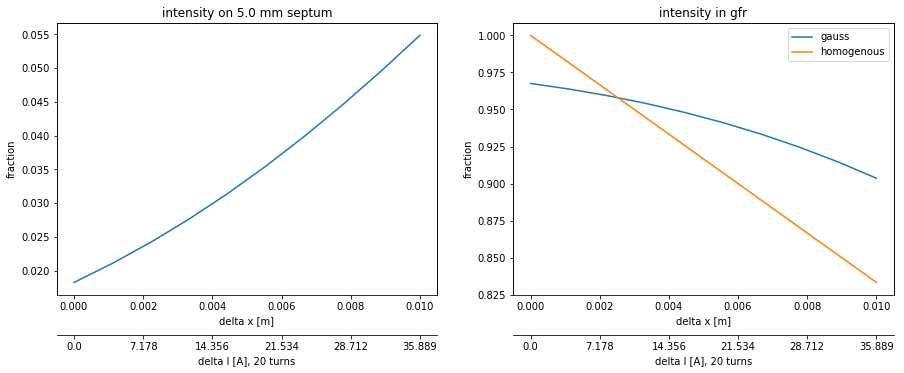

In [102]:

f_sep = num_gauss_int(2*sigma-w/2,2*sigma+w/2,delta_x_max,10,100,sigma)

f_gfr = num_gauss_int(-3*sigma, 2*sigma,delta_x_max,10,100,sigma)

fig, axes = plt.subplots(1,2, figsize = (15,5))

for i,dic in enumerate([f_sep,f_gfr]):

    ax = axes[i]
    ax.plot(*zip(*sorted(dic.items())))
    if i == 1:
        ax.plot(np.linspace(0,delta_x_max,10),1-np.linspace(0,delta_x_max,10)/(4*sigma))
        ax.legend(['gauss','homogenous'])
        
    ax.set_xlabel('delta x [m]')
    ax.set_ylabel('fraction')
    
    titles = ['on {} mm septum'.format(w*1e3), 'in gfr']
    ax.set_title('intensity ' + titles[i])

    #convert spat. to curr_off
    def dx_to_dI(dx):
        dThet = dx/l
        dI = brho*lgap/(u0*kick_l*N)*dThet
        return round(dI,3)

    cplt.add_axis(ax, 'x', dx_to_dI, 'delta I [A], {} turns'.format(N) )

plt.show()

### air coil vs. ferrites

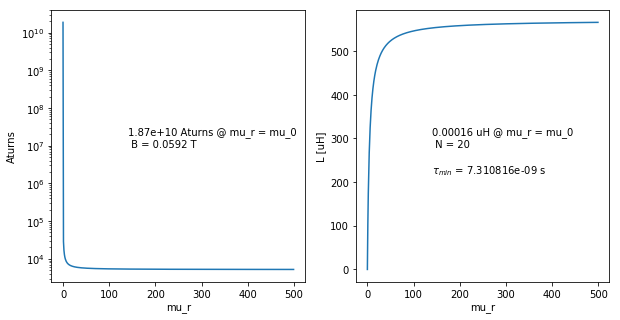

assumed length in material: 0.5 m


In [63]:
# Aturns + inductivity
N = 20
l_mat = 0.5
mu_r = np.arange(c.mu_0,500)

def NI(mu_r):
    NI = B * l_mat/(c.mu_0*mu_r)*(1+lgap/l_mat*mu_r)
    return NI

def L(mu_r):
    A = hap * kick_l # area of B-flux
    L = N**2 /(l_mat/(c.mu_0*mu_r*A)+lgap/(c.mu_0*A))
    return L

fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].semilogy(mu_r,NI(mu_r))
ax[0].text(0.3,0.5,'{:.2e} Aturns @ mu_r = mu_0 \n B = {} T'.format(NI(c.mu_0),B), transform=ax[0].transAxes)
ax[0].set_ylabel('Aturns')
ax[0].set_xlabel('mu_r')

ax[1].plot(mu_r,L(mu_r)*1e6)
ax[1].text(0.3,0.5,'{:.5f} uH @ mu_r = mu_0 \n N = {}'.format(L(c.mu_0)*1e6,N), transform=ax[1].transAxes)
ax[1].text(0.3,0.4,r'$\tau_{{min}}$ = {:2e} s'.format(L(c.mu_0)/R(N)), transform=ax[1].transAxes)
ax[1].set_ylabel('L [uH]')
ax[1].set_xlabel('mu_r')

plt.show()
print('assumed length in material: {} m'.format(l_mat))